## **Underground Porject**

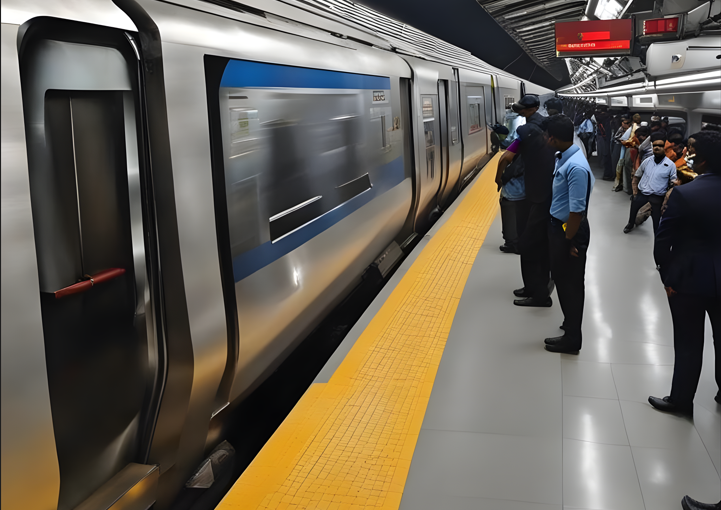

In [ ]:
#Let's check gpu or cpu in runtime
import subprocess
# Run the nvidia-smi command to check GPU information
gpu_info = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
# Print the GPU information
print(gpu_info.stdout)

Sat Sep  2 13:00:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5

%cd {HOME}/yolov5
!pip install -r requirements.txt

from IPython import display
display.clear_output()

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.168 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


## **Detectron**

In [ ]:
#Let's install detectron
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


## **Supervision**

In [ ]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


In [ ]:
Underground_VIDEO_PATH = "UNDERGROUND.mp4"
Underground_screen_PATH = "undergroundscreen.png"

In [ ]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:00, 180MB/s]                           


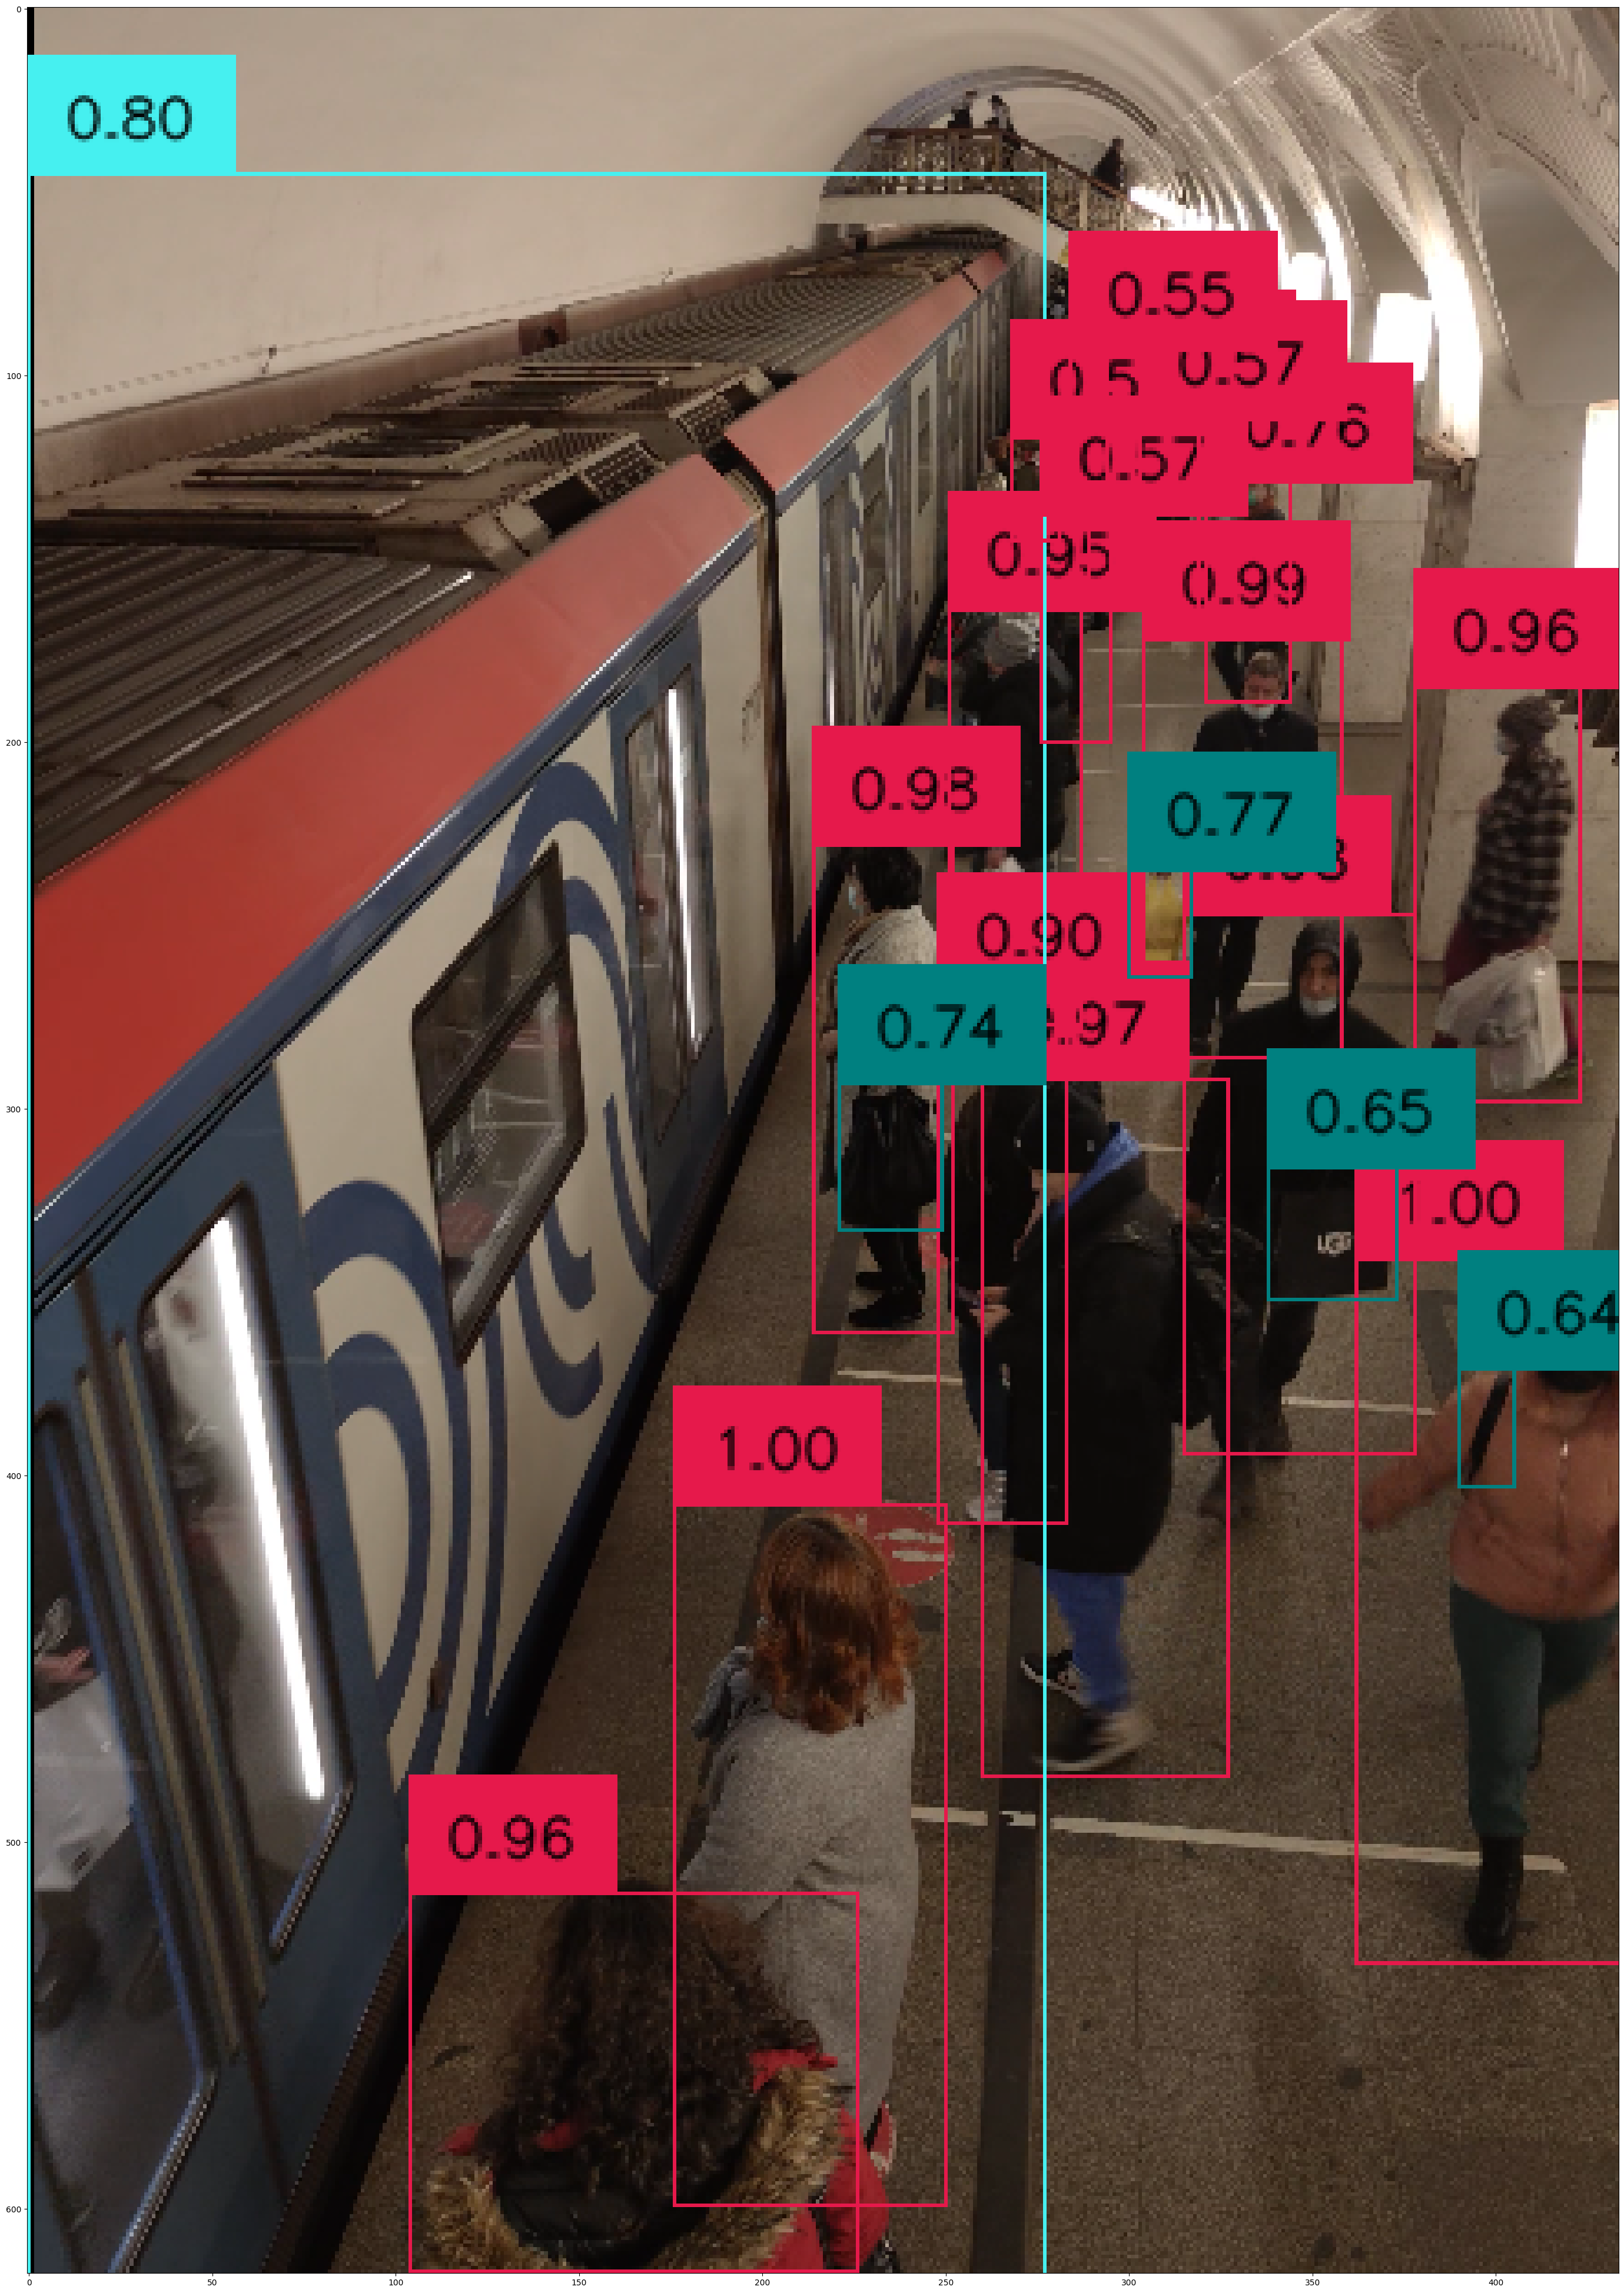

In [ ]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(Underground_screen_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (50, 50))

## **Let's detect humans which detections confidence is greater than 0.8**

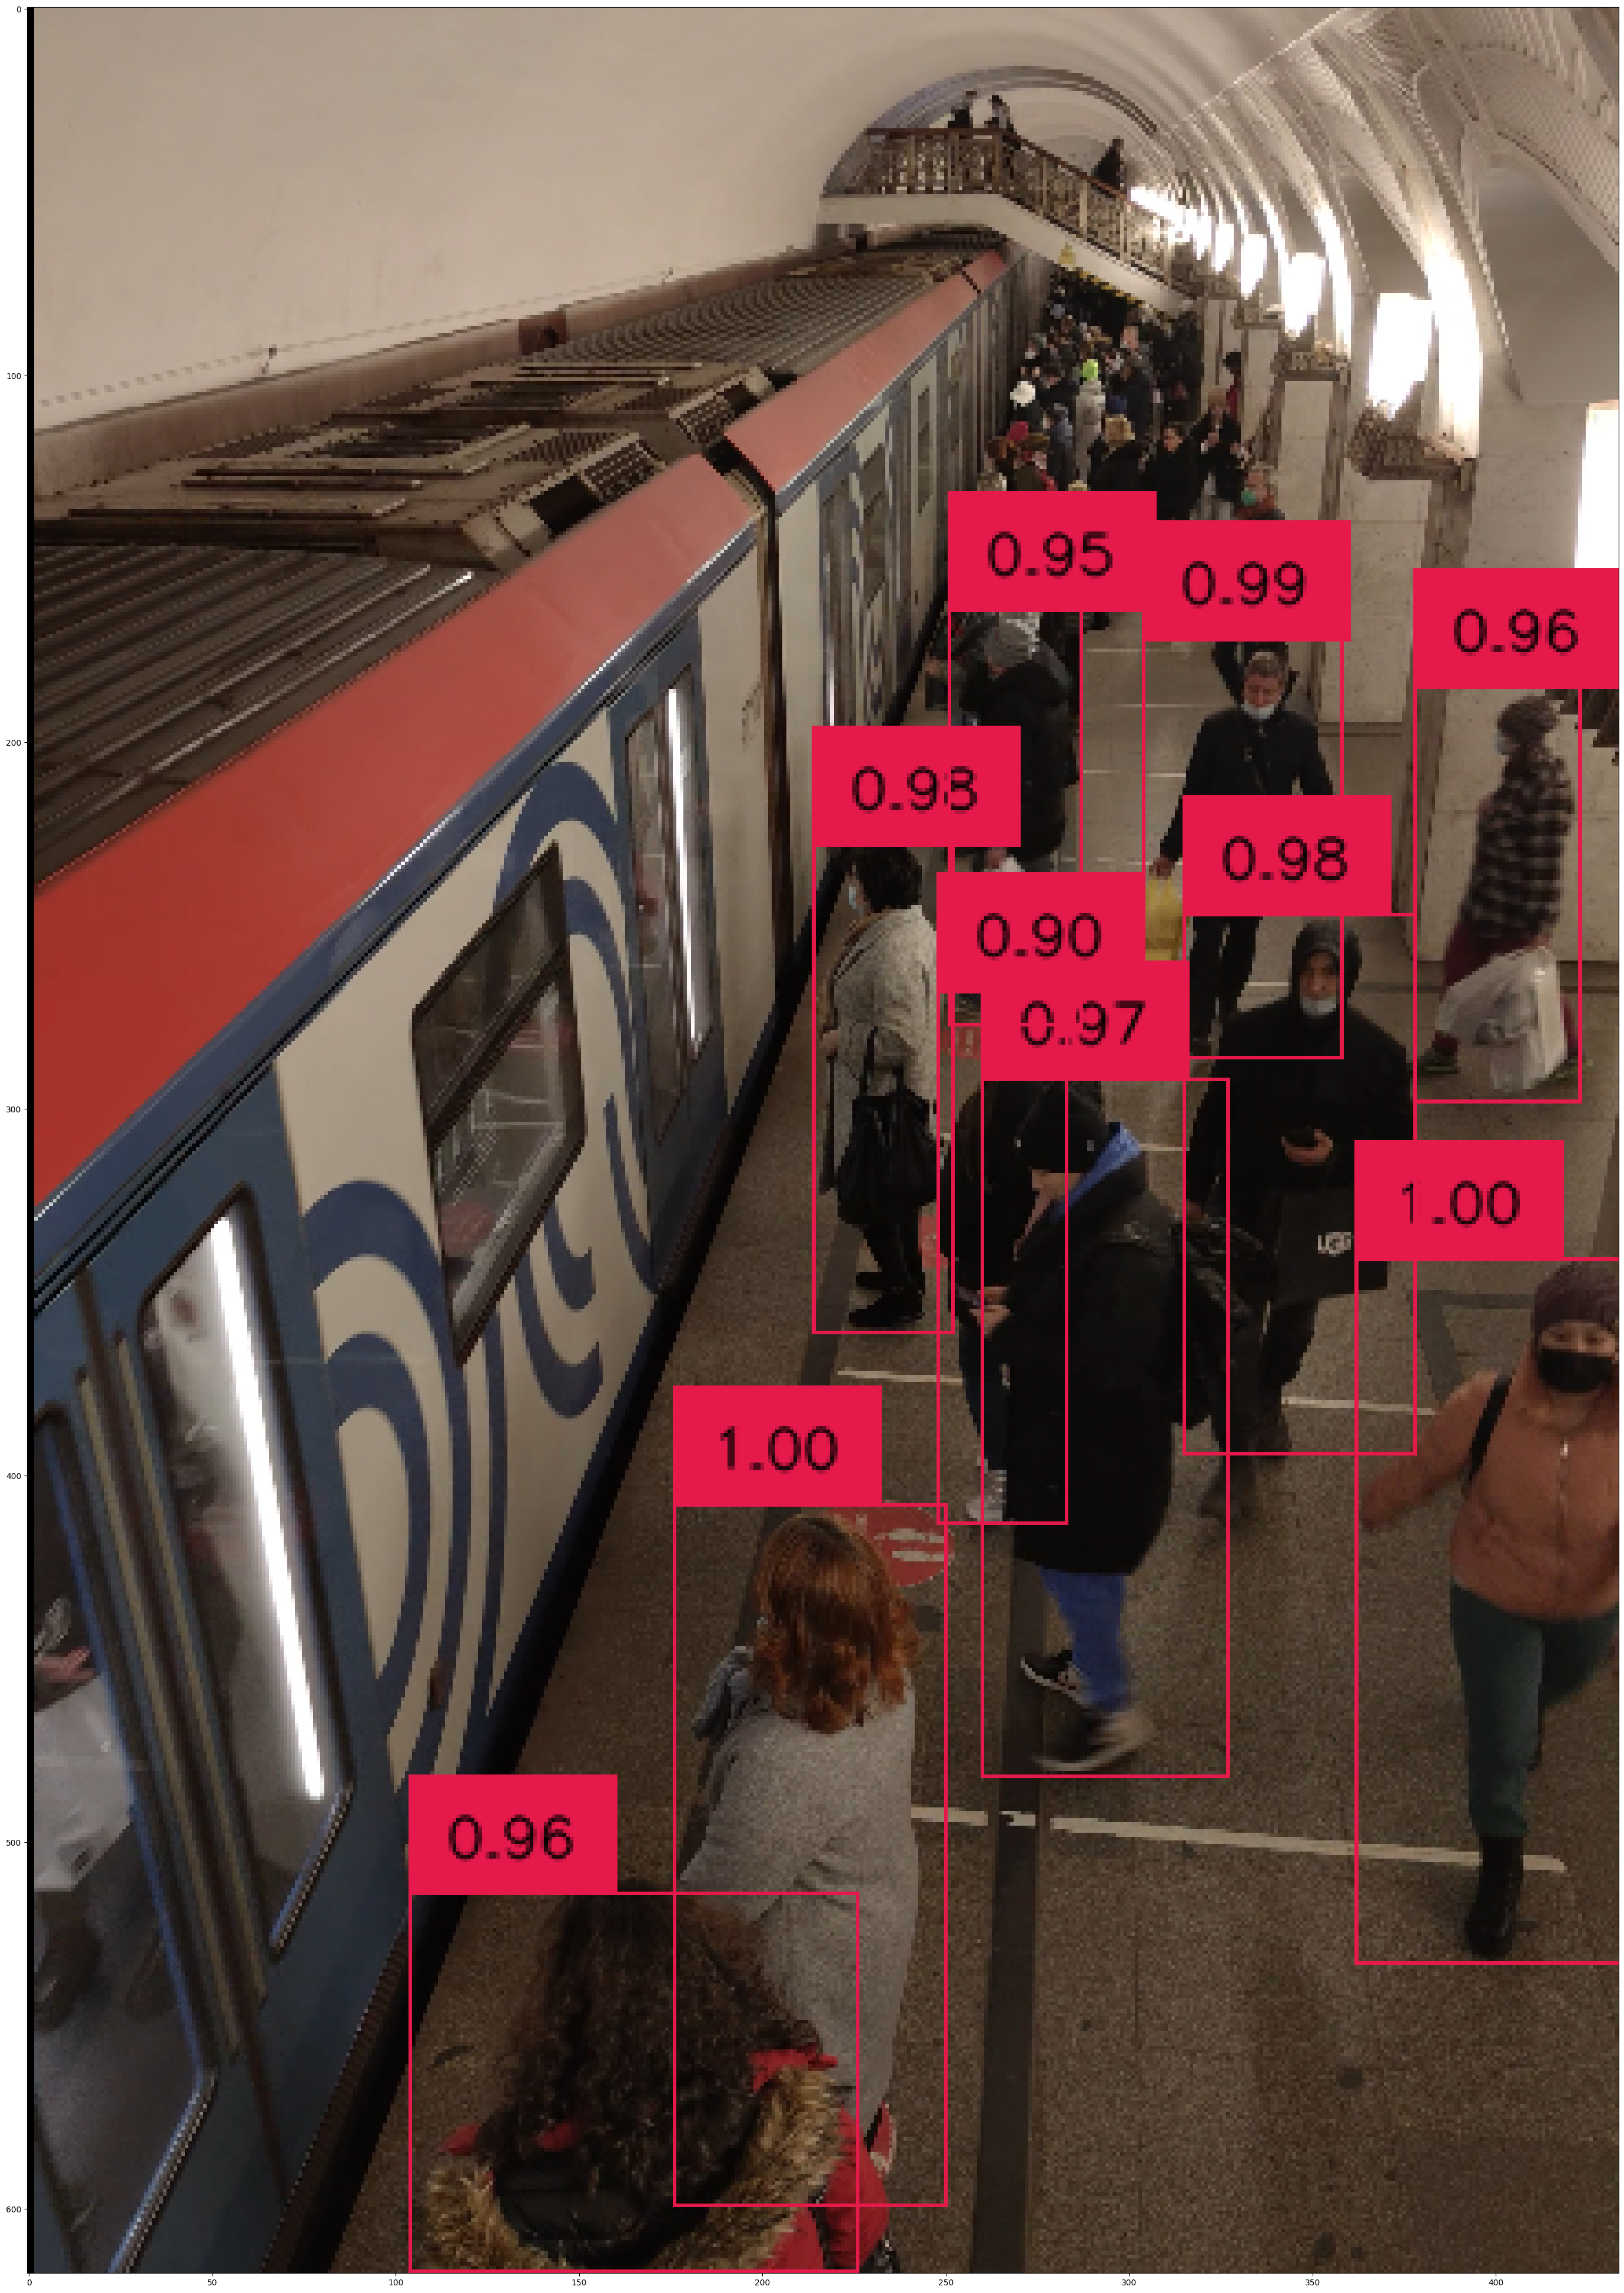

In [ ]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(Underground_screen_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)

# Filter detections based on confidence threshold (e.g., 0.8)
confidence_threshold = 0.8
mask = detections.confidence >= confidence_threshold
filtered_detections = sv.Detections(
    xyxy=detections.xyxy[mask],
    confidence=detections.confidence[mask],
    class_id=detections.class_id[mask]
)

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
frame = box_annotator.annotate(scene=frame, detections=filtered_detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (50, 50))

## **Let's find count of humans**

In [ ]:
# Let's find count the number of detected objects without threshold
num_detected_objects = len(detections)
print("Number of detected objects:", num_detected_objects)

Number of detected objects: 21


In [ ]:
# Let's find count the number of detected objects with threshold
num_detected_objects = len(filtered_detections)
print("Number of detected objects:", num_detected_objects)

Number of detected objects: 10


In [ ]:
#Let's find count of human for various thresholds
threshold_dict = {}
import numpy as np
for i in np.arange(0.3,0.9,0.10000):
      # Filter detections based on confidence threshold (e.g., 0.8)
      confidence_threshold = i
      mask = detections.confidence >= confidence_threshold
      filtered_detections = sv.Detections(
          xyxy=detections.xyxy[mask],
          confidence=detections.confidence[mask],
          class_id=detections.class_id[mask]
      )
      num_detected_objects = len(filtered_detections)
      threshold_dict[round(i,2)] = num_detected_objects

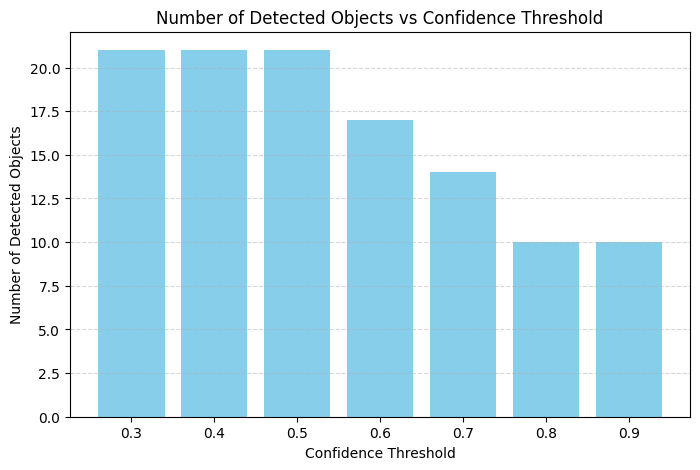

In [ ]:
#Let's display as visual
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
thresholds = list(threshold_dict.keys())
counts = list(threshold_dict.values())
# Create the bar plot
plt.bar(thresholds, counts, color='skyblue',width=0.08)
# Add labels and title
plt.xlabel('Confidence Threshold')
plt.ylabel('Number of Detected Objects')
plt.title('Number of Detected Objects vs Confidence Threshold')
# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.5)
# Show the plot
plt.show()

## **Draw polygon**

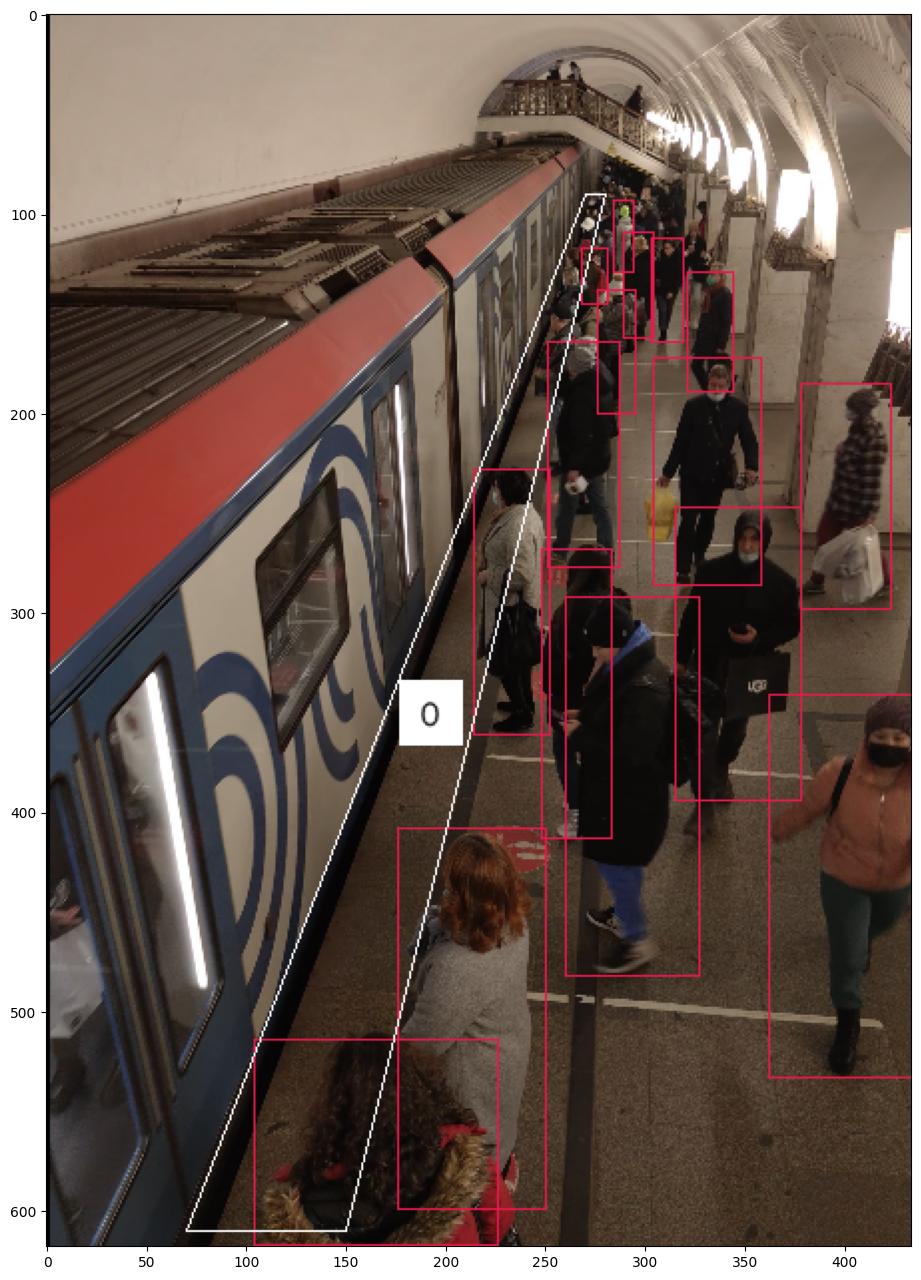

In [ ]:
# initiate polygon zone
polygon = np.array([
    [270, 90],
    [70, 610],
    [150, 610],
    [280, 90]
])
video_info = sv.VideoInfo.from_video_path(Underground_screen_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=1, text_thickness=1, text_scale=0.5)

# extract video frame
generator = sv.get_video_frames_generator(Underground_screen_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.1)
frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

## **From Other Frame**

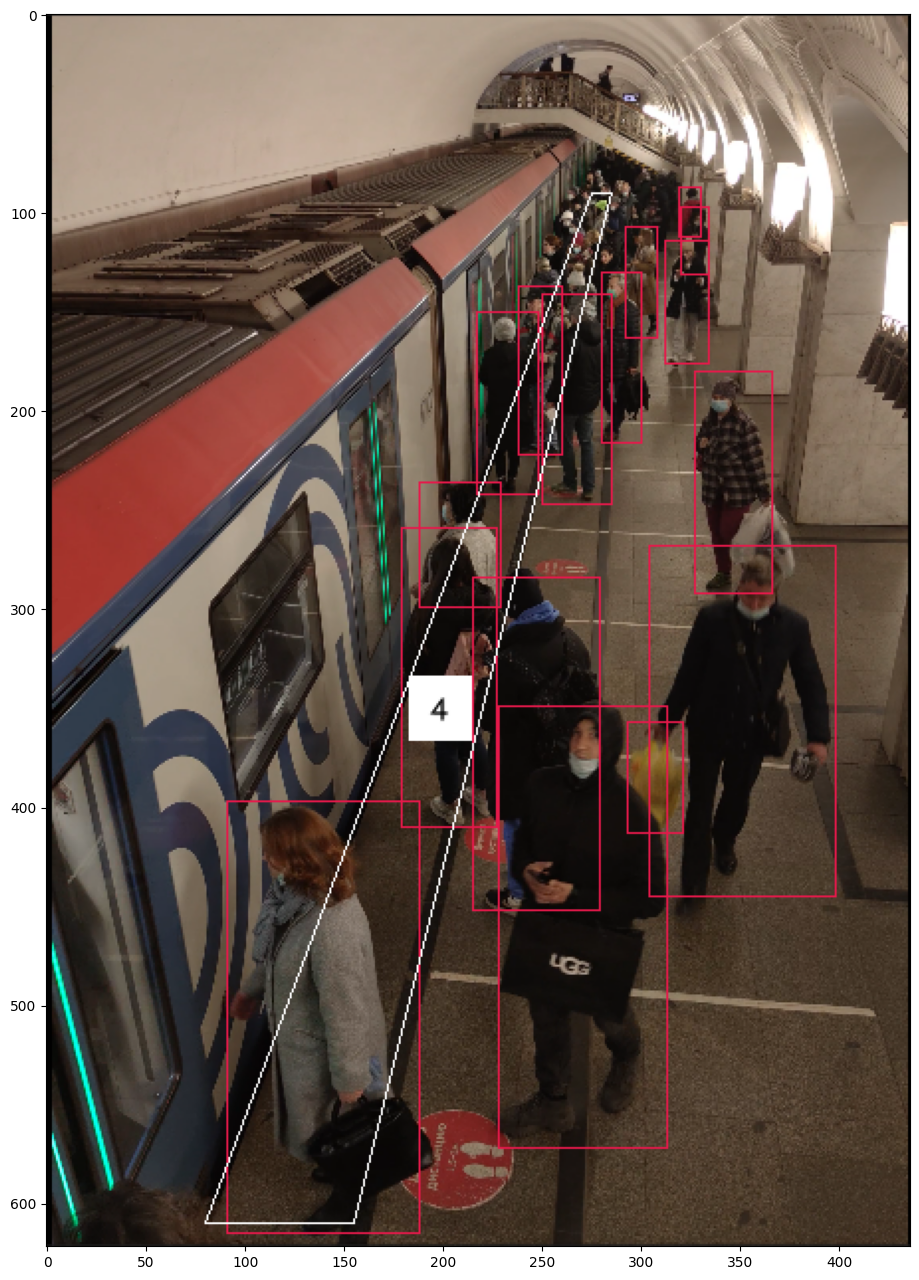

In [ ]:
# initiate polygon zone
polygon = np.array([
    [275, 90],
    [80, 610],
    [155, 610],
    [285, 90]
])
video_info = sv.VideoInfo.from_video_path('/content/undergroundscreen2.png')
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=1, text_thickness=1, text_scale=0.5)

# extract video frame
generator = sv.get_video_frames_generator('/content/undergroundscreen2.png')
iterator = iter(generator)
frame = next(iterator)

# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.1)
frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)
frame = zone_annotator.annotate(scene=frame)


%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

## **Other Example**

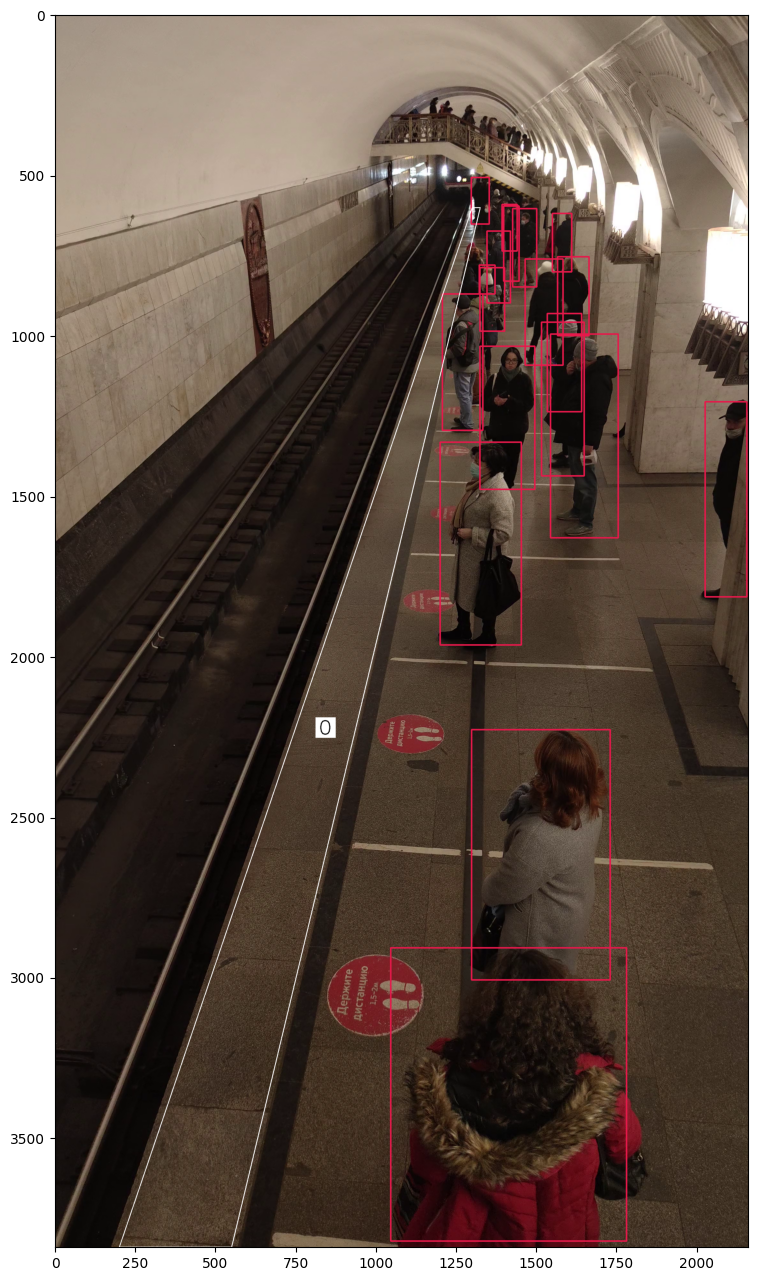

In [ ]:
# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path('/content/UNDERGROUND.mp4')
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=2, text_thickness=2, text_scale=2)

# extract video frame
generator = sv.get_video_frames_generator('/content/UNDERGROUND.mp4')
iterator = iter(generator)
frame = next(iterator)

# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=3, text_scale=1)
frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)
frame = zone_annotator.annotate(scene=frame)


%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path('/content/UNDERGROUND.mp4')
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, i: int) -> np.ndarray:
    print('frame', i)
    # detect
    outputs = predictor(frame)
    detections = sv.Detections(
        xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
        confidence=outputs["instances"].scores.cpu().numpy(),
        class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
    )
    detections = detections[detections.class_id == 0]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
    frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)
    frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path='/content/UNDERGROUND.mp4', target_path=f"{HOME}/subway-result.mp4", callback=process_frame)

from IPython import display
display.clear_output()

## **The End**